# Final Project
## EX 4: Classification of sign language hand gestures with CNN
In this exercise we will develop a convolutional network model to classify the hand gestures. We will develop a model that, given an image $x$ (an array of pixels), produces a classification. $y_a, y_b,....,y_y$ such that yi is the probability that the image is of the hand sign $i$ and $\sum {y_i=1}$. This is a supervised learning problem, as we have a set of images with their corresponding hand signs.

## Data Preperation

In [1]:
import urllib.request
import os
from os.path import splitext
import zipfile
import scipy
import numpy as np
import pandas as pd
import keras
import random

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.color import rgb2gray

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import skimage.transform
import skimage as sk

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import pickle

Using TensorFlow backend.


**Data.** The data is the same as in Ex 3. However, we are going to work on cropped versions of the original images: we will use the bounding boxes, given in the metadata csv files, to crop the images. The idea is that the model
from Ex 3 and the model we develop here will consist of a pipeline: the first model looks at an image and finds a bounding box, the second model only looks inside the bounding box and classifies the hand gesture.

In [ ]:
url = 'https://github.com/yoavram/Sign-Language/raw/master/Dataset.zip'
filename = '../data/sign-lang'
if not os.path.exists('../data'):
    os.mkdir('../data')
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

After extracting the zip file to the folder data/sign-lang, we have 7 folders, one for each person (user). Each folder has 10 images of that person gesturing one of 24 signs: the ABC letters, not including J and Z.

In [ ]:
# Opening the Zip:
zf = zipfile.ZipFile(filename)

In [4]:
bboxes = []

for file in zf.namelist():
    basename,extension = splitext(file)
    if extension == '.csv':
        bboxes.append(pd.read_csv(zf.open(file), index_col=None, header=0))
        
bboxes = pd.concat(bboxes)
bboxes.head()

,image,top_left_x,top_left_y,bottom_right_x,bottom_right_y
0,user_10/A0.jpg,186,84,286,184
1,user_10/A1.jpg,186,84,286,184
2,user_10/A2.jpg,185,90,285,190
3,user_10/A3.jpg,180,88,290,198
4,user_10/A4.jpg,173,102,293,222


In [ ]:
bboxes_np = bboxes[['top_left_x', 'top_left_y', 'bottom_right_x', 'bottom_right_y']].values

In [6]:
# Find the max size of box to reshape later
max_width = (bboxes.bottom_right_x - bboxes.top_left_x).min()
max_height = (bboxes.bottom_right_y - bboxes.top_left_y).min()

print(max_width, max_height)

70 70


In [ ]:
# Cut an image by it's bounding box and resize it
def preprocess_on_img(img, bbox):
    
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    # [height, weight]
    img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    img = skimage.transform.resize(img, (max_height, max_width))
    return img

In [8]:
bboxes.head()

,image,top_left_x,top_left_y,bottom_right_x,bottom_right_y
0,user_10/A0.jpg,186,84,286,184
1,user_10/A1.jpg,186,84,286,184
2,user_10/A2.jpg,185,90,285,190
3,user_10/A3.jpg,180,88,290,198
4,user_10/A4.jpg,173,102,293,222


In [9]:
# We collect all images into an array
x = []
full_img = []
img_labels = []

for i, file in enumerate(bboxes['image'].values):
    path = f"Dataset/{file}"
    basename,extension = splitext(path)
    if extension == '.jpg':
        temp_pic = plt.imread(zf.open(path))
        
        # Saving the original pictures
        temp_full = np.array(temp_pic)
        full_img.append(temp_full)
        
        # Saving the cutted pictures
        pic = preprocess_on_img(temp_pic, bboxes_np[i])
        temp = np.array(pic)
        x.append(temp)
        
        img_labels.append(os.path.basename(file)[0])
        
x = np.array(x)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [10]:
print(x.shape, bboxes_np.shape)

(1680, 70, 70, 3) (1680, 4)


In [ ]:
def show_preprocessed_img(i):
    a = full_img[i]
    b = bboxes_np[i]
    plt.imshow(preprocess_on_img(a,b))
    plt.show()

# for i in np.random.randint(0, len(full_img), size=5):
#     show_preprocessed_img(i)

In [12]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U' ,'V', 'W', 'X', 'Y']


def onehot(labels):
    nsamples = len(labels)
    Y = np.zeros((nsamples, len(np.unique(labels))))
    Y[np.arange(nsamples), [labels.index(x) for x in labels]] = 1
    return Y

onehot_encoder = onehot(labels)
onehot_encoder[:2]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [13]:
# Now we create Y

y = []

for i in img_labels:
    pos = labels.index(i)
    y.append(onehot_encoder[pos])
    
y = np.array(y)
print (x.shape)
print(np.array(img_labels).shape)

(1680, 70, 70, 3)
(1680,)


In [14]:
from sklearn.model_selection import train_test_split

## We need to keep order

# train_size = 0.67
# X_train, X_test, Y_train, Y_test = train_test_split(x,y, shuffle=False, test_size=(1-train_size), train_size=train_size)
test_prob = 1. / 6

mask = np.random.choice([0, 1], size=(x.shape[0]), p=[test_prob, 1 - test_prob])
print(mask[:20])

X_train = x[mask == 1]
X_test = x[mask == 0]

Y_train = y[mask == 1]
Y_test = y[mask == 0]

img_train = np.array(img_labels)[mask == 1]
img_test = np.array(img_labels)[mask == 0]

print(X_train.shape, X_test.shape, img_train.shape)

[1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0]
(1422, 70, 70, 3) (258, 70, 70, 3) (1422,)


In [ ]:
def random_rotation(image_array):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

# dictionary of the transformations we defined earlier
available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip
}

In [16]:
# Data augmentation, adding more training samples


num_training_required = len(X_train) * 2
x_temp = []
y_temp = []

for i in range(num_training_required):
    
    if (i+1) % 1000 == 0:
        print(f"Round: {i+1}")
    
    # random image from the folder
    img_index = random.choice(range(len(X_train)))
    
    # read image as an two dimensional array of pixels
    image_to_transform = X_train[img_index]
    
    # random num of transformation to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    transformed_image = None
    for _ in range(num_transformations_to_apply):
        # random transformation to apply for a single image
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)

    x_temp.append(transformed_image)
    y_temp.append(Y_train[img_index])
X_train = np.concatenate((X_train, x_temp))
Y_train = np.concatenate((Y_train, y_temp))

Round: 1000
Round: 2000


## Keras model

In [ ]:
def display_image(im, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(im, cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])

In [18]:
X_train.shape

(4266, 70, 70, 3)

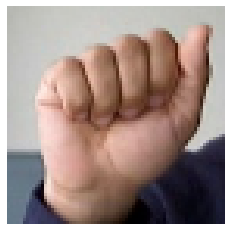

In [19]:
display_image(X_train[4])

## Training

In [20]:
#Initialising the CNN
classifier = keras.models.Sequential()

# Adding first convolutional layer, followed by pooling, and dropout
classifier.add(keras.layers.Conv2D(32, (3, 3), input_shape = (200, 200, 3), activation = 'relu'))
classifier.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(keras.layers.Dropout(0.25))

# Adding second convolutional layer, followed by pooling, and dropout
classifier.add(keras.layers.Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(keras.layers.Dropout(0.25))

# Adding third convolutional layer, followed by pooling, and dropout
classifier.add(keras.layers.Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(keras.layers.Dropout(0.25))

# Flattening
classifier.add(keras.layers.Flatten())

# Full connection
classifier.add(keras.layers.Dense(units = 128, activation = 'relu'))
classifier.add(keras.layers.Dense(units = 24, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
# Train the data with training set, and check the result with validation accuracy
# history = classifier.fit(x=X_train, y=Y_train, batch_size=128, epochs=100, 
#     validation_data=(X_test, Y_test),).history

In [ ]:
model = keras.models.Sequential()
model.add(
    keras.layers.Conv2D(32, (5, 5)))
model.add(
    keras.layers.ReLU())
model.add(
    keras.layers.MaxPool2D())
model.add(
    keras.layers.Conv2D(64, (5, 5)))
model.add(
    keras.layers.ReLU())
model.add(
    keras.layers.MaxPool2D())
model.add(
    keras.layers.Flatten())
model.add(
    keras.layers.Dense(1024))
model.add(
    keras.layers.ReLU())
model.add(
    keras.layers.Dropout(0.5))
model.add(
    keras.layers.Dense(len(labels)))
model.add(
    keras.layers.Softmax())
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(), 
    metrics=[keras.metrics.categorical_accuracy]
)


In [ ]:
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=0, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', mode='max', verbose=0, save_best_only=True)

In [24]:
history = model.fit(x=X_train, y=Y_train, batch_size=256, epochs=200, 
    validation_data=(X_test, Y_test), callbacks=[es, mc]
).history

Instructions for updating:
Use tf.cast instead.
Train on 4266 samples, validate on 258 samples
Epoch 1/200
4266/4266 [==============================] - 5s 1ms/step - loss: 3.1136 - categorical_accuracy: 0.1132 - val_loss: 2.5508 - val_categorical_accuracy: 0.3488
Epoch 2/200
4266/4266 [==============================] - 2s 471us/step - loss: 2.0939 - categorical_accuracy: 0.3978 - val_loss: 1.2375 - val_categorical_accuracy: 0.6667
Epoch 3/200
4266/4266 [==============================] - 2s 463us/step - loss: 1.3556 - categorical_accuracy: 0.5792 - val_loss: 0.8498 - val_categorical_accuracy: 0.7093
Epoch 4/200
4266/4266 [==============================] - 2s 461us/step - loss: 0.9187 - categorical_accuracy: 0.7023 - val_loss: 0.6748 - val_categorical_accuracy: 0.7868
Epoch 5/200
4266/4266 [==============================] - 2s 468us/step - loss: 0.6351 - categorical_accuracy: 0.7979 - val_loss: 0.5395 - val_categorical_accuracy: 0.8450
Epoch 6/200
4266/4266 [=============================

In [ ]:
# model.save('../data/keras_cnn_model.ex4')
model = load_model('best_model.h5')
with open("../data/keras_cnn_history.p", "wb") as f:
    pickle.dump(history, f)

In [26]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=0)
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 1.000, Test: 0.946


In [ ]:
def onehot_decoder(arr):
    return labels[np.argmax(arr)]

def predict_img(i):
    img = full_img[i]
    cropped_img = x[i]
    predicted = onehot_decoder(model.predict(np.array([cropped_img]))[0])
    
    plt.imshow(img)
    plt.text(10,30, f"Actual: {img_labels[i]}\nPredicted: {predicted}", color="Yellow")
    plt.show()

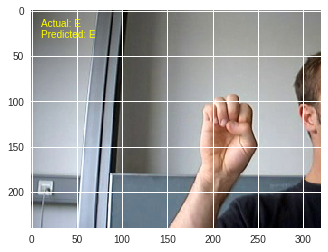

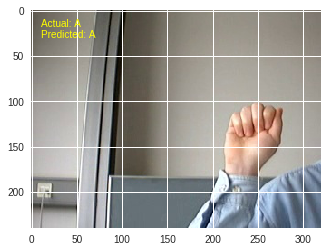

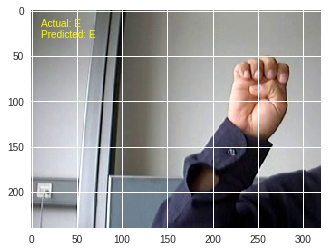

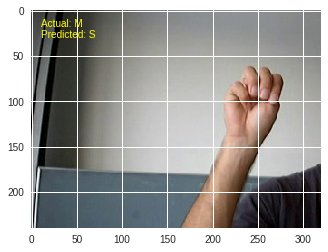

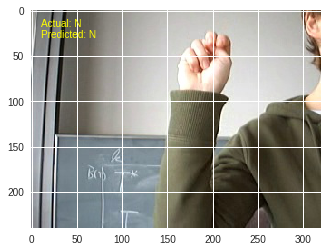

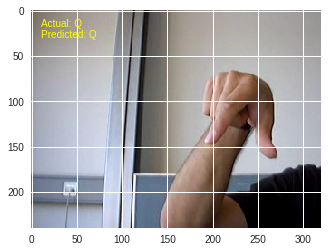

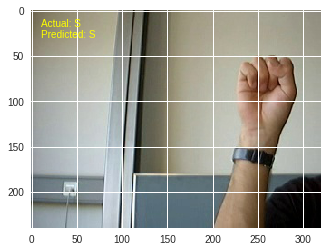

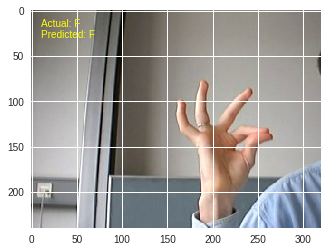

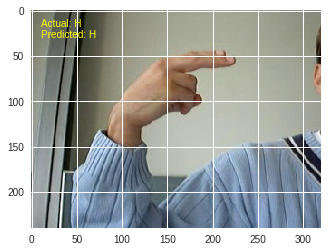

In [28]:
for i in np.random.randint(0, len(full_img), size=9):
    predict_img(i)

We identify which classes are more commonly mis-classified:
compute and plot the accuracy of each separate class (hand sign), and illustrate
which classes have relatively lower accuracy. These should be the classes we
attempt to deal with next (if we were to continue this exercise), maybe by
checking what they are confused with.

In [ ]:
categories = {label:[] for label in labels}
for img, onehot in zip(X_test, Y_test):
    categories[onehot_decoder(onehot)].append(img)

In [30]:
accurecies = []
for label in categories.keys():
    images = np.array(categories[label])
    predictions = model.predict(images)
    predictions_indices = np.argmax(predictions, axis=1)
    
    correct_index = labels.index(label)
    correct = (predictions_indices == correct_index).sum()
    accurecy = correct / len(images)
    accurecies.append(accurecy)
    print(f"Sign {label} accurecy:{accurecy:.2f} correct: {correct:2} incorrect: {len(images) - correct}")

Sign A accurecy:1.00 correct:  9 incorrect: 0
Sign B accurecy:1.00 correct: 10 incorrect: 0
Sign C accurecy:1.00 correct: 14 incorrect: 0
Sign D accurecy:1.00 correct: 15 incorrect: 0
Sign E accurecy:1.00 correct:  6 incorrect: 0
Sign F accurecy:0.93 correct: 13 incorrect: 1
Sign G accurecy:1.00 correct: 15 incorrect: 0
Sign H accurecy:1.00 correct: 10 incorrect: 0
Sign I accurecy:0.91 correct: 10 incorrect: 1
Sign K accurecy:1.00 correct: 15 incorrect: 0
Sign L accurecy:0.85 correct: 11 incorrect: 2
Sign M accurecy:0.79 correct: 11 incorrect: 3
Sign N accurecy:0.91 correct: 10 incorrect: 1
Sign O accurecy:1.00 correct:  9 incorrect: 0
Sign P accurecy:1.00 correct:  9 incorrect: 0
Sign Q accurecy:1.00 correct:  7 incorrect: 0
Sign R accurecy:1.00 correct: 10 incorrect: 0
Sign S accurecy:0.89 correct:  8 incorrect: 1
Sign T accurecy:1.00 correct: 10 incorrect: 0
Sign U accurecy:0.93 correct: 13 incorrect: 1
Sign V accurecy:1.00 correct:  7 incorrect: 0
Sign W accurecy:1.00 correct:  4 i

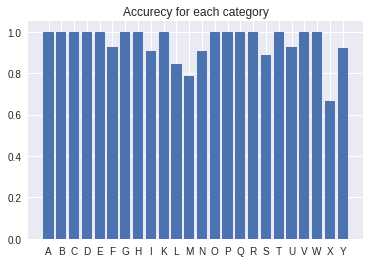

In [31]:
plt.bar(labels, accurecies)
plt.title("Accurecy for each category")
plt.show()